KeyboardInterrupt: 

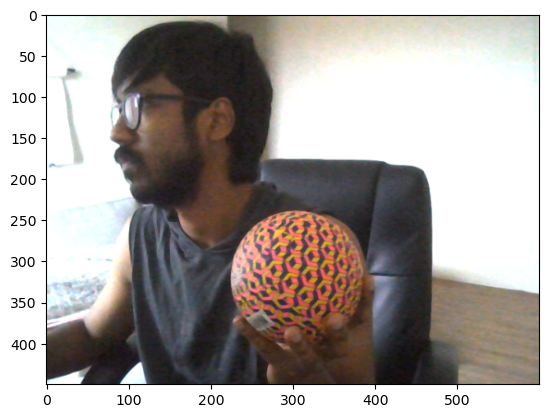

In [3]:
from collections import deque
from imutils.video import VideoStream
import numpy as np
import cv2
import imutils
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# In a Jupyter Notebook, set the arguments directly
video_path = None  # Replace with your video path or set to None for webcam
buffer_size = 64  # Max buffer size

greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)
pts = deque(maxlen=buffer_size)

# Start the video stream based on the video_path
if video_path is None:
    vs = VideoStream(src=0).start()
else:
    vs = cv2.VideoCapture(video_path)

# Allow the camera or video file to warm up
time.sleep(2.0)

while True:
    # grab the current frame
    ret, frame = vs.read() if video_path is not None else (True, vs.read())

    # if we did not grab a frame (end of video or error), then break
    if frame is None or not ret:
        break

    # resize the frame, blur it, and convert it to the HSV color space
    frame = imutils.resize(frame, width=600)
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small blobs left in the mask
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # find contours in the mask and initialize the current (x, y) center of the ball
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None

    # only proceed if at least one contour was found
    if len(cnts) > 0:
        # find the largest contour in the mask, then use it to compute the minimum enclosing circle and centroid
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

        # only proceed if the radius meets a minimum size
        if radius > 10:
            # draw the circle and centroid on the frame, then update the list of tracked points
            cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)

    # update the points queue
    pts.appendleft(center)

    # loop over the set of tracked points
    for i in range(1, len(pts)):
        # if either of the tracked points are None, ignore them
        if pts[i - 1] is None or pts[i] is None:
            continue
        # otherwise, compute the thickness of the line and draw the connecting lines
        thickness = int(np.sqrt(buffer_size / float(i + 1)) * 2.5)
        cv2.line(frame, pts[i - 1], pts[i], (0, 0, 255), thickness)

    # Display the resulting frame
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    display(plt.gcf())  # Show current frame
    clear_output(wait=True)  # Clear the output before the next frame

# Release the video source when the job is finished
if video_path is None:
    vs.stop()
else:
    vs.release()
